In [ ]:
import os
import struct

import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import seaborn as sns

sns.set_theme(context="poster", style="whitegrid")

# from sklearn.model_selection import train_test_split
# import torch
# from torch import nn
# from torch.utils.data import Dataset, DataLoader
# from torch import optim

# %matplotlib widget

Read EMG data.

In [2]:
fsEmg = 2000

with open(r"C:\Users\morly\OneDrive\Desktop\emg_2024-11-21_12-45-42.bin", "rb") as f:
    nCh = struct.unpack("<I", f.read(4))[0]
    bSig = bytes(f.read())
emg = np.frombuffer(bSig, dtype=np.float32).reshape(-1, nCh).T

# Get timestamp and trigger
emgTs, emg = emg[-1], emg[:-1]
emgTrigger, emg = emg[-1], emg[:-1]

emg.shape, emgTrigger.shape

((64, 216328), (216328,))

Read Manus data.

In [3]:
fsManus = 120


def read_manus_data(dir_path: str, acq_name: str, use_trigger: bool = False):

    with open(os.path.join(dir_path, f"manusData_{acq_name}.bin"), "rb") as f:
        nCh = struct.unpack("<I", f.read(4))[0]
        bSig = bytes(f.read())
    manusData_ = np.frombuffer(bSig, dtype=np.float32).reshape(-1, nCh).T
    manusData_ = manusData_[:-1]  # get rid of BioGUI timestamp

    with open(os.path.join(dir_path, f"manusTs_{acq_name}.bin"), "rb") as f:
        nCh = struct.unpack("<I", f.read(4))[0]
        bSig = bytes(f.read())
    manusTs_ = np.frombuffer(bSig, dtype=np.float32).reshape(-1, nCh).T
    manusTs_ = manusTs_[:-1]  # get rid of BioGUI timestamp

    trigger_ = None
    if use_trigger:
        trigger_, manusData_ = manusData_[-1], manusData_[:-1]
    manusTs_ = manusTs_[0]

    return manusData_, manusTs_, trigger_


manusData, manusTs, manusTrigger = read_manus_data(
    dir_path=r"C:\Users\morly\OneDrive\Desktop",
    acq_name="2024-11-21_12-45-42",
    use_trigger=True,
)
manusData.shape, manusTs.shape, manusTrigger.shape

((24, 13011), (13011,), (13011,))

Read the force data.

In [4]:
fsForce = 120

with open(r"C:\Users\morly\OneDrive\Desktop\force_2024-11-21_12-45-42.bin", "rb") as f:
    nCh = struct.unpack("<I", f.read(4))[0]
    bSig = bytes(f.read())
force = np.frombuffer(bSig, dtype=np.float32).reshape(-1, nCh).T

# Get timestamp and trigger
forceTs, force = force[-1], force[:-1]
forceTrigger, force = force[-1], force[:-1]

force.shape, forceTrigger.shape

((3, 13003), (13003,))

Compute delays.

In [5]:
print(f"First EMG trigger: {np.flatnonzero(emgTrigger)[0] / fsEmg}")
print(f"First MANUS trigger: {np.flatnonzero(manusTrigger)[0] / fsManus}")
print(f"First Force trigger: {np.flatnonzero(forceTrigger)[0] / fsForce}")

First EMG trigger: 7.24
First MANUS trigger: 7.5
First Force trigger: 7.466666666666667


Align EMG with force.

In [6]:
delayS = (
    np.flatnonzero(forceTrigger)[0] / fsForce - np.flatnonzero(emgTrigger)[0] / fsEmg
)
delay = int(round(delayS * fsForce))
print(f"Delay between EMG and Force: {delayS:.3f} s ({delay} samples)")

force = force[:, delay:]
forceTs = forceTs[delay:]
forceTs - forceTs[0]
forceTrigger = forceTrigger[delay:]

Delay between EMG and Force: 0.227 s (27 samples)


Align MANUS with other signals.

In [7]:
delayS = (
    np.flatnonzero(manusTrigger)[0] / fsManus - np.flatnonzero(emgTrigger)[0] / fsEmg
)
delay = int(round(delayS * fsManus))
print(f"Delay between other signals and MANUS: {delayS:.3f} s ({delay} samples)")

manusData = manusData[:, delay:]
manusTs = manusTs[delay:]
manusTs = manusTs - manusTs[0]
manusTrigger = manusTrigger[delay:]

Delay between other signals and MANUS: 0.260 s (31 samples)


Plot triggers.

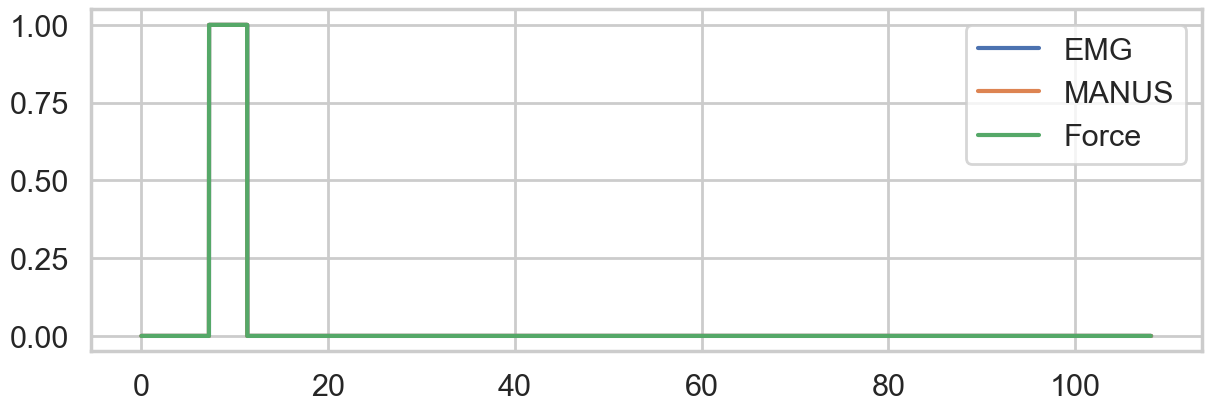

In [ ]:
emgTs = np.arange(emg.shape[1]) / fsEmg
forceTs = np.arange(force.shape[1]) / fsForce

fig, ax = plt.subplots(sharex="all", figsize=(12, 4), layout="constrained")
ax.plot(emgTs, emgTrigger, label="EMG")
ax.plot(manusTs, manusTrigger, label="MANUS")
ax.plot(forceTs, forceTrigger, label="Force")

ax.legend()
plt.savefig("acq1_trigger.png")

Plot signals.

In [9]:
def waveform_length(x: np.ndarray, win_len_ms: float, fs: float) -> np.ndarray:
    """Compute the waveform length of a given signal."""
    win_len = int(round(win_len_ms / 1000 * fs))
    abs_diff = np.abs(np.diff(x, axis=0, prepend=0))
    kernel = np.ones(win_len)
    wl = np.stack(
        [
            signal.convolve(abs_diff[:, i], kernel, mode="valid")
            for i in range(x.shape[1])
        ],
        axis=1,
    )
    return wl


def root_mean_square(x: np.ndarray, win_len_ms: float, fs: float) -> np.ndarray:
    """Compute the RMS of a given signal."""
    win_len = int(round(win_len_ms / 1000 * fs))
    x_sq = x**2
    kernel = np.ones(win_len) / win_len
    rms = np.stack(
        [
            np.sqrt(signal.convolve(x_sq[:, i], kernel, mode="valid"))
            for i in range(x.shape[1])
        ],
        axis=1,
    )
    return rms

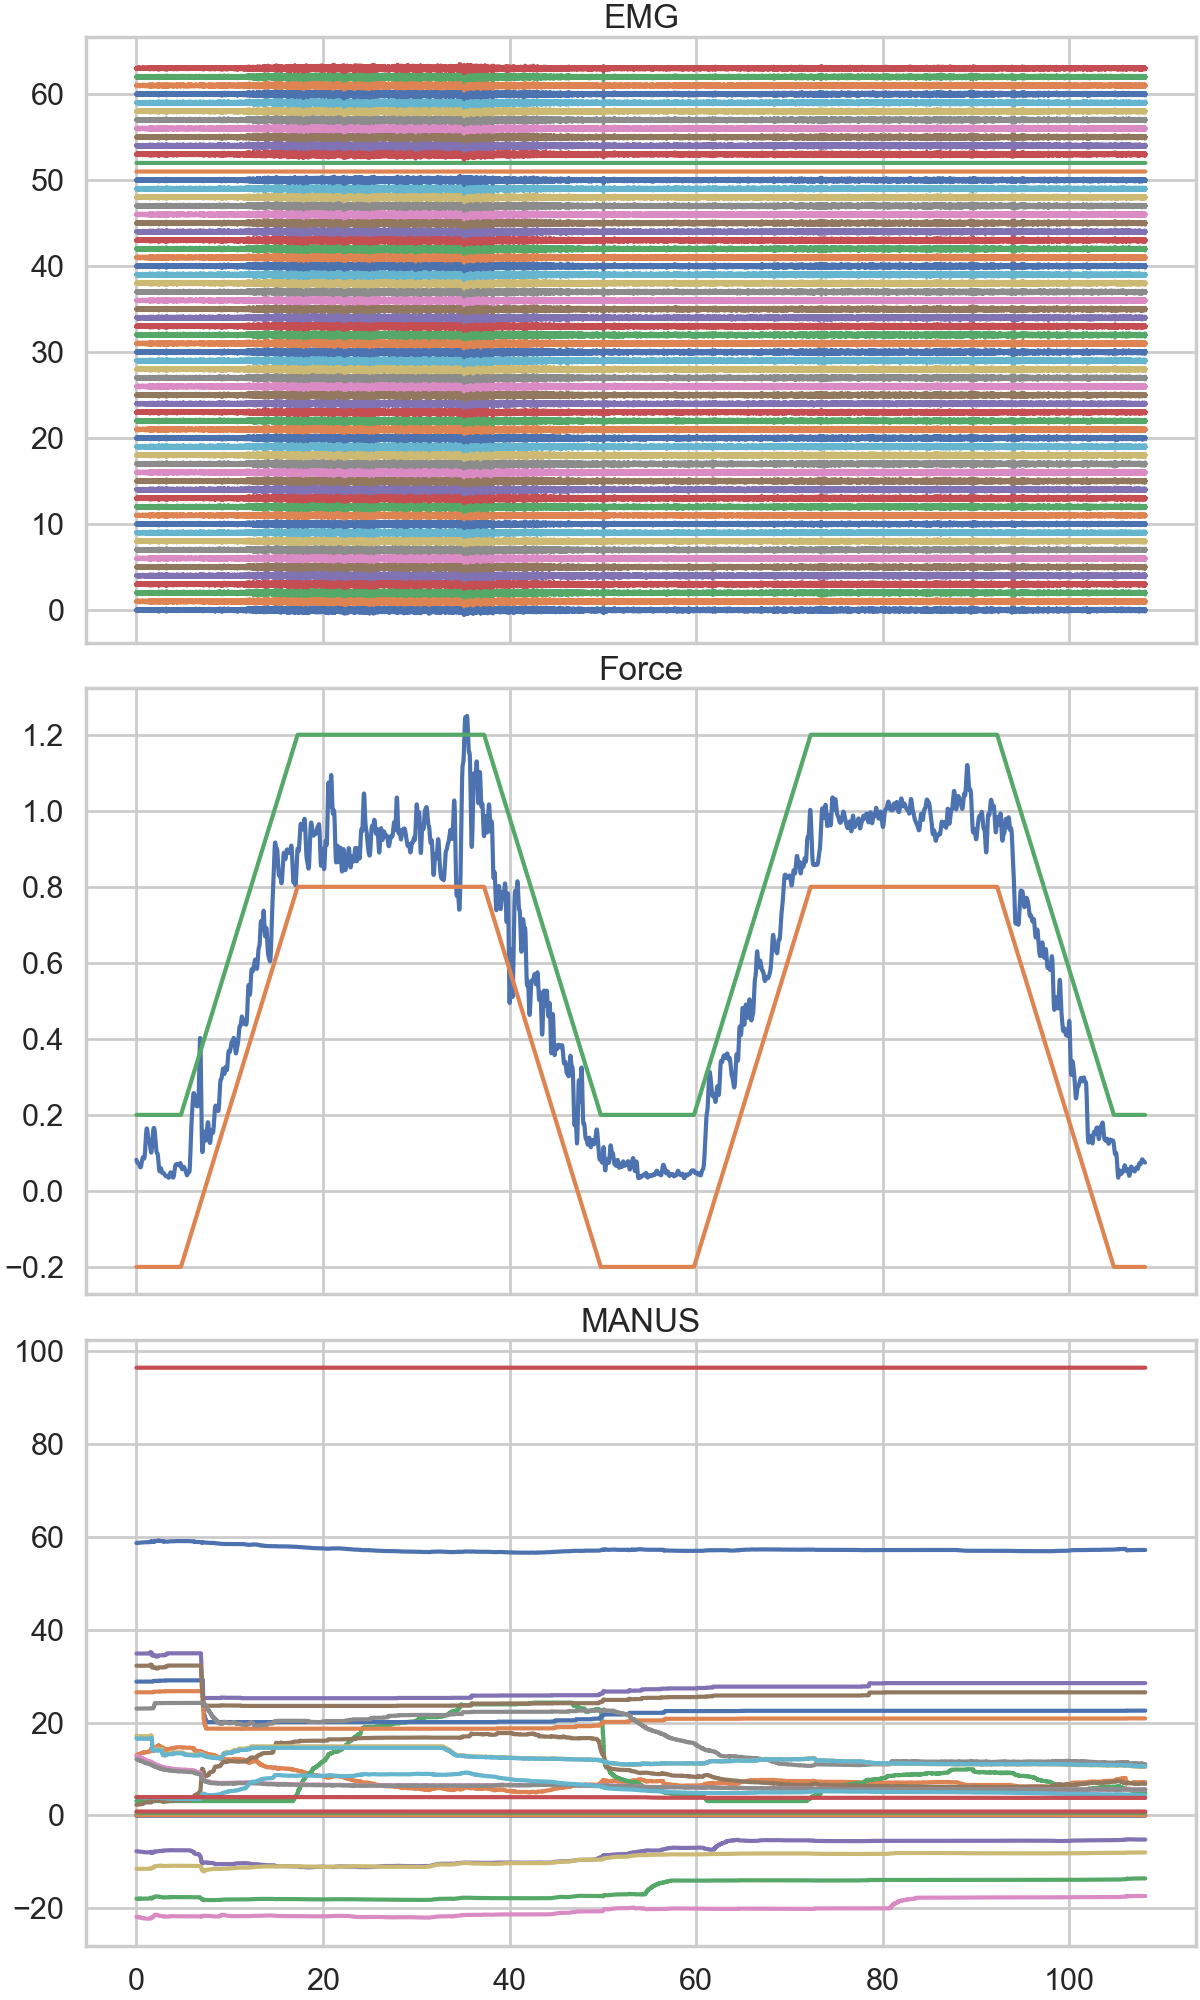

In [ ]:
fig, axes = plt.subplots(nrows=3, sharex="all", figsize=(12, 20), layout="constrained")

sos = signal.butter(10, (49, 51), "bandstop", output="sos", fs=fsEmg)
emg_flt = signal.sosfiltfilt(sos, emg)
sos = signal.butter(10, (20, 500), "bandpass", output="sos", fs=fsEmg)
emg_flt = signal.sosfiltfilt(sos, emg_flt)

sos = signal.butter(10, (4), "lowpass", output="sos", fs=fsForce)
force_flt = force.copy()
force_flt[0] = signal.sosfiltfilt(sos, force[0])

axes[0].set_title("EMG")
# emg_feat = waveform_length(emg_flt.T, 1000, fsEmg).T
# emg_feat = np.pad(emg_feat, pad_width=((0, 0), (emg_flt.shape[1] - emg_feat.shape[1], 0)))
for i, emg_i in enumerate(emg_flt):
    axes[0].plot(emgTs, 1 * i + emg_i)

axes[1].set_title("Force")
axes[1].plot(forceTs, force_flt[0])
axes[1].plot(forceTs, force_flt[1])
axes[1].plot(forceTs, force_flt[2])

axes[2].set_title("MANUS")
for manus_i in manusData:
    axes[2].plot(manusTs, manus_i)


plt.show()

Create dataset.

In [7]:
winSizeMs = 200  # ms
stepSizeMs = 50  # ms

winSizeEmg = int(round(winSizeMs / 1000 * 4000))
winSizeManus = int(round(winSizeMs / 1000 * 120))
stepSizeEmg = int(round(stepSizeMs / 1000 * 4000))
stepSizeManus = int(round(stepSizeMs / 1000 * 120))

X = np.zeros(shape=(0, nChEmg), dtype=np.float32)
y = np.zeros(shape=(0, nChManus), dtype=np.float32)

curIdxEmg = 0
curIdxManus = 0
while curIdxEmg + winSizeEmg < nSampEmg:
    # if triggerManus[curIdxManus] != 0:  # ignore rest
    wl = np.abs(
        np.diff(emg[:, curIdxEmg : curIdxEmg + winSizeEmg], axis=-1, prepend=0)
    ).sum(axis=-1)
    X = np.concatenate([X, wl.reshape(1, -1)])
    y = np.concatenate([y, manus[:, curIdxManus + winSizeManus].reshape(1, -1)])

    curIdxEmg += stepSizeEmg
    curIdxManus += stepSizeManus

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (3691, 16) (3691, 20)
Test set: (1583, 16) (1583, 20)


Create Torch dataset and MLP regressor.

In [8]:
class EMGDataset(Dataset):
    def __init__(self, emg_data, joint_angles):
        self.emg_data = torch.tensor(emg_data, dtype=torch.float32)
        self.joint_angles = torch.tensor(joint_angles, dtype=torch.float32)

    def __len__(self):
        return len(self.emg_data)

    def __getitem__(self, idx):
        return self.emg_data[idx], self.joint_angles[idx]


class FCBlock(nn.Module):

    def __init__(self, in_features: int, out_features: int, use_bn: bool) -> None:
        super().__init__()
        self._layers = nn.ModuleList(
            [nn.Linear(in_features, out_features, bias=not use_bn)]
        )
        if use_bn:
            self._layers.append(nn.BatchNorm1d(out_features))
        self._layers.append(nn.ReLU(inplace=True))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for l_ in self._layers:
            x = l_(x)

        return x


class WLRegr(nn.Module):

    def __init__(
        self,
        in_features: int,
        hidden_layers_sizes: list[int],
        out_features: int,
        use_bn: bool = True,
    ) -> None:
        super().__init__()

        self._layers = nn.ModuleList(
            [FCBlock(in_features, hidden_layers_sizes[0], use_bn)]
        )
        for i in range(len(hidden_layers_sizes) - 1):
            self._layers.append(
                FCBlock(hidden_layers_sizes[i], hidden_layers_sizes[i + 1], use_bn)
            )
        self._output = nn.Linear(hidden_layers_sizes[-1], out_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for l_ in self._layers:
            x = l_(x)

        return self._output(x)

Define training loop.

In [9]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        for features, joint_angles in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, joint_angles)
            loss.backward()
            optimizer.step()
            mae = (outputs - joint_angles).abs().mean().item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, MAE: {mae}")


def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_mae = 0.0
    with torch.no_grad():
        for emg, joint_angles in test_loader:
            outputs = model(emg)
            loss = criterion(outputs, joint_angles)
            test_loss += loss.item()
            test_mae += (outputs - joint_angles).abs().mean().item()
    print(f"Test Loss: {test_loss / len(test_loader):.4f}")
    print(f"Test MAE: {test_mae / len(test_loader):.4f}")
    model.train()

Train and evaluate MLP.

In [10]:
train_dataset = EMGDataset(X_train, y_train)
test_dataset = EMGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = WLRegr(in_features=16, hidden_layers_sizes=[64, 128, 64], out_features=20)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, num_epochs=50)

evaluate_model(model, train_loader, criterion)
evaluate_model(model, test_loader, criterion)

Epoch 1/50, Loss: 1784.0934, MAE: 27.1087589263916
Epoch 2/50, Loss: 443.0182, MAE: 13.377174377441406
Epoch 3/50, Loss: 896.0860, MAE: 20.993022918701172
Epoch 4/50, Loss: 313.4758, MAE: 12.733975410461426
Epoch 5/50, Loss: 471.0061, MAE: 15.02133560180664
Epoch 6/50, Loss: 330.4393, MAE: 12.752237319946289
Epoch 7/50, Loss: 235.7645, MAE: 10.560615539550781
Epoch 8/50, Loss: 410.4626, MAE: 13.101171493530273
Epoch 9/50, Loss: 171.7084, MAE: 9.039600372314453
Epoch 10/50, Loss: 145.2265, MAE: 8.216001510620117
Epoch 11/50, Loss: 177.5576, MAE: 8.651313781738281
Epoch 12/50, Loss: 254.5435, MAE: 9.711804389953613
Epoch 13/50, Loss: 147.4637, MAE: 8.234807968139648
Epoch 14/50, Loss: 179.6971, MAE: 8.4695463180542
Epoch 15/50, Loss: 335.6728, MAE: 11.940085411071777
Epoch 16/50, Loss: 66.0729, MAE: 5.689403057098389
Epoch 17/50, Loss: 379.9035, MAE: 11.89021110534668
Epoch 18/50, Loss: 136.9547, MAE: 7.499319553375244
Epoch 19/50, Loss: 170.5721, MAE: 8.464334487915039
Epoch 20/50, Loss

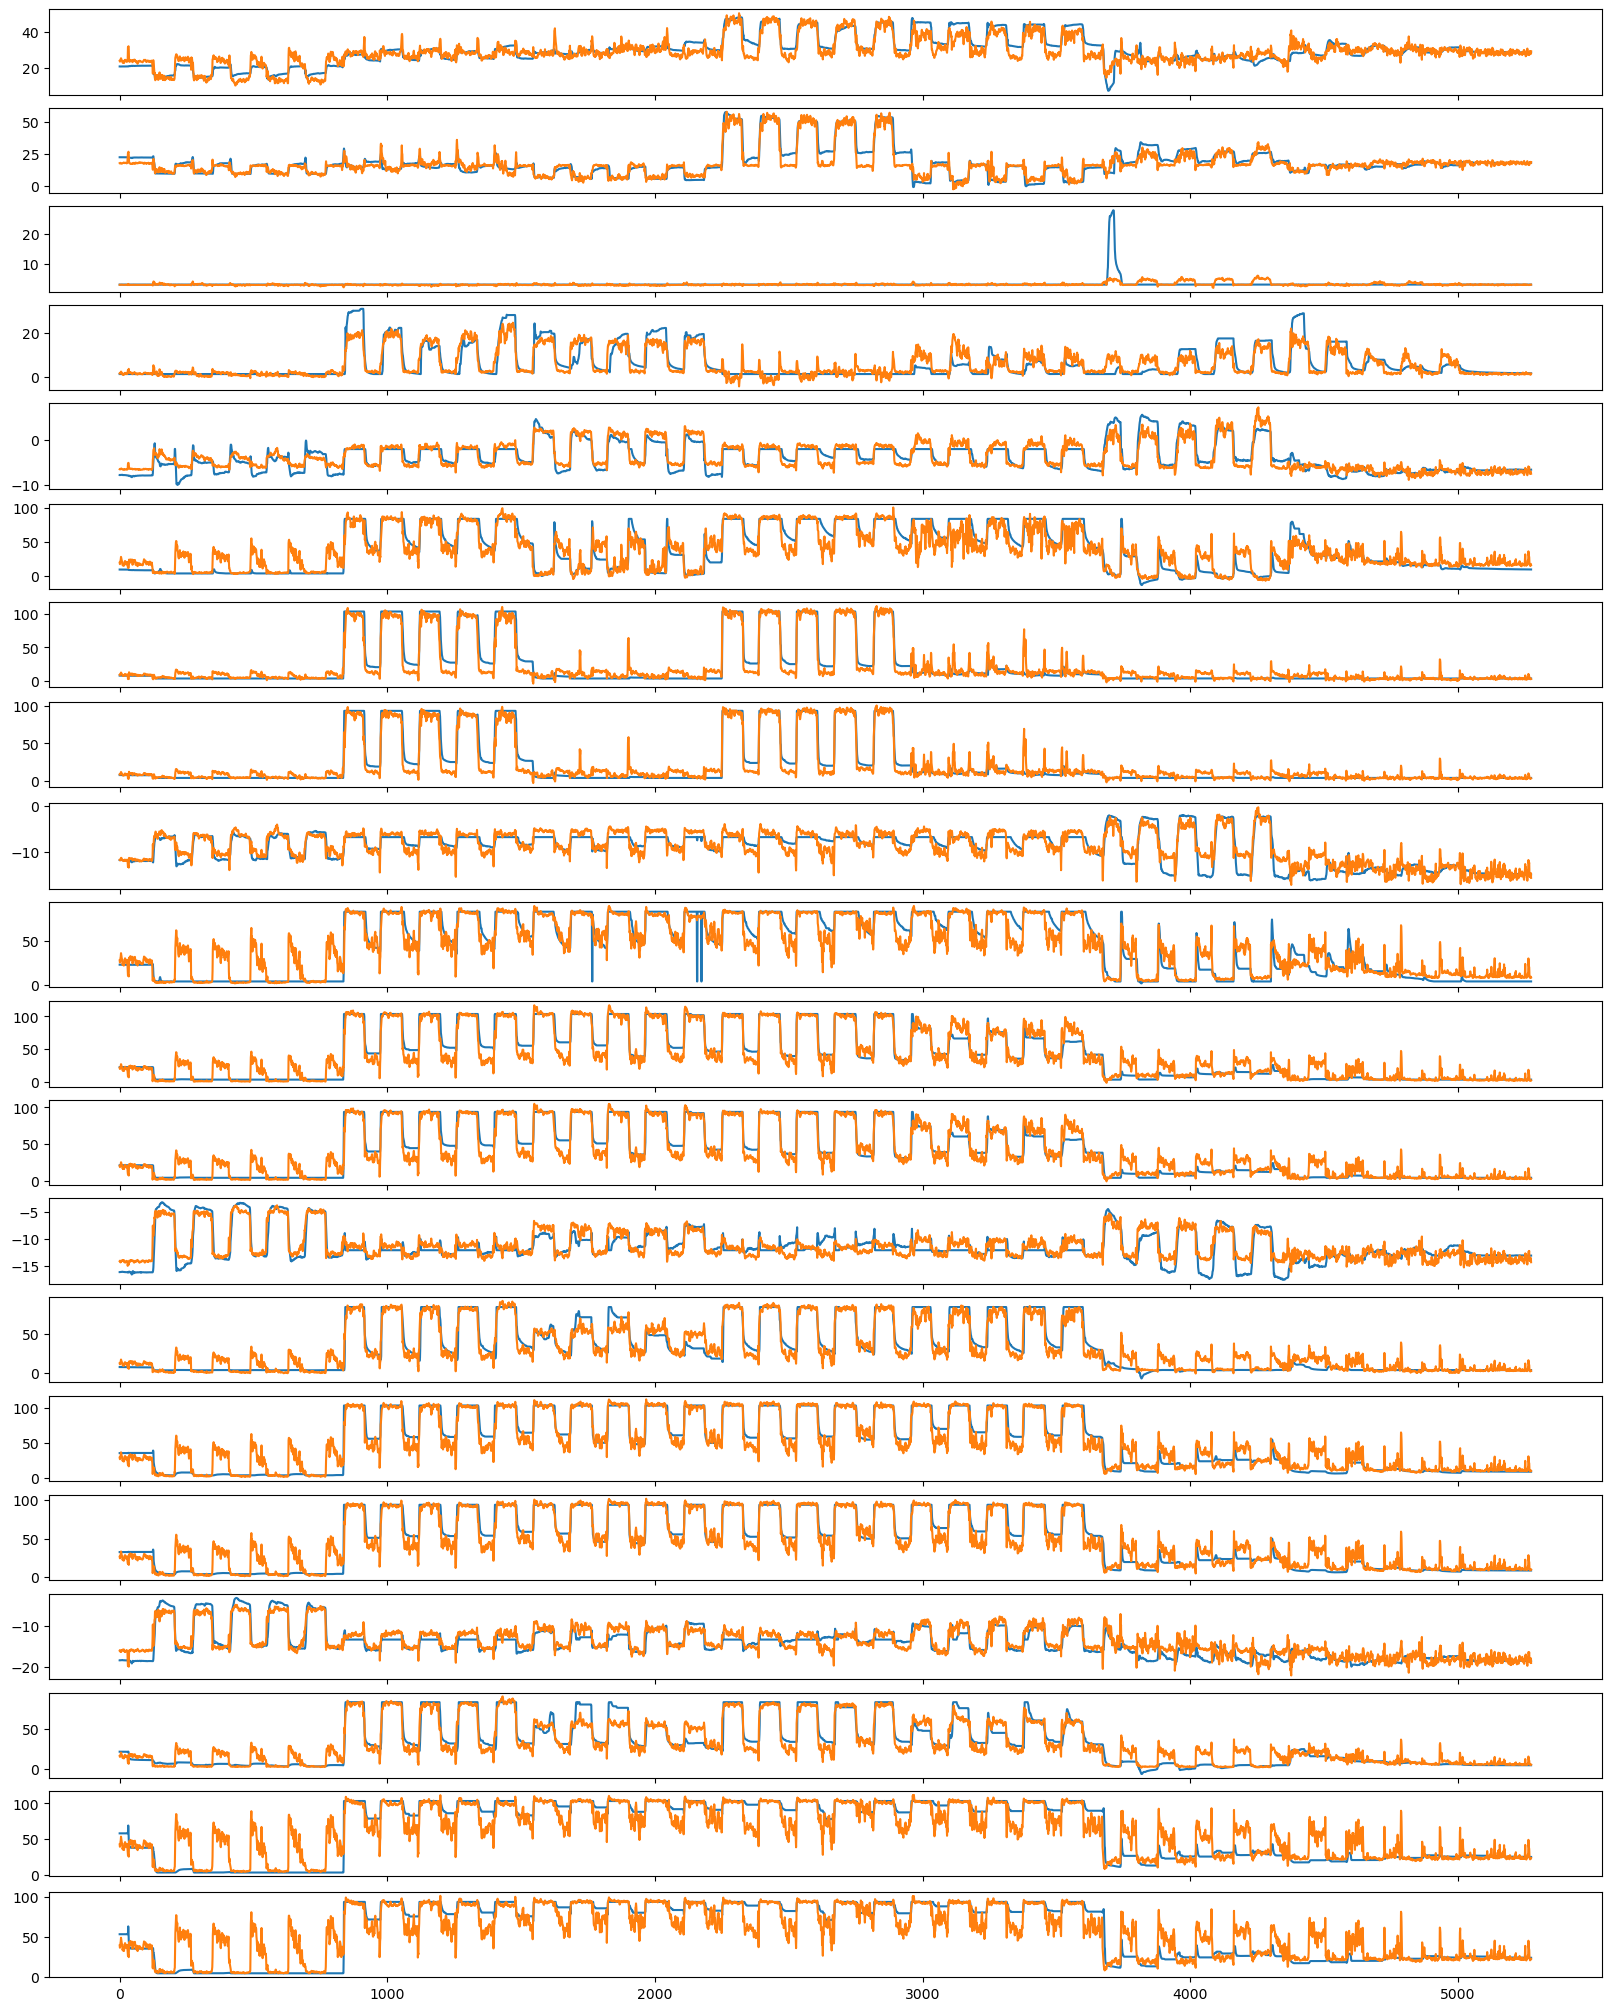

In [11]:
with torch.no_grad():
    output = model(torch.tensor(X, dtype=torch.float32)).numpy()

fig, axes = plt.subplots(
    nrows=y.shape[1], sharex="all", figsize=(16, 20), layout="constrained"
)
for i in range(y.shape[1]):
    axes[i].plot(y[:, i])
    axes[i].plot(output[:, i])
plt.show()